ResNet Model Implementation - NHFI DATASET

Importing Libraries

In [6]:
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.resnet import ResNet50
from keras.layers import GlobalAveragePooling2D
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import Callback

ResNet - Load data, defining emotion classes, batch side & image size code - NHFI

In [7]:
# Set the path to the folder containing images
data_path = "C:/Users/HP/Desktop/MSc Thesis/DATASETS/Human face datasets"

# Define the emotion classes
emotion_classes = ['anger', 'contempt', 'disgust', 'fear', 'happiness',  'neutrality', 'sadness', 'surprise']

# Set the image size and batch size
image_size = (48, 48)
batch_size = 32

ResNet - Data Processing - NHFI

In [8]:
# Load the images and labels
def load_data():
    images = []
    labels = []
    for emotion_class in emotion_classes:
        class_path = os.path.join(data_path, emotion_class)
        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)
            image = Image.open(image_path).convert('RGB')  # Convert the images to RGB
            image = image.resize((48, 48))  # Resize the images if need be...
            images.append(np.array(image))
            labels.append(emotion_classes.index(emotion_class))
    return np.array(images), np.array(labels)
images, labels = load_data()

# Split the data into training, validation and testing sets
X_temp, X_test, y_temp, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

# Normalize the pixel values between 0 and 1
X_train = X_train.astype('float32') / 255
X_val = X_val.astype('float32') / 255
X_test = X_test.astype('float32') / 255

# Convert the labels to one-hot encoding
num_classes = len(emotion_classes)
y_train = np.eye(num_classes)[y_train]
y_val = np.eye(num_classes)[y_val]
y_test = np.eye(num_classes)[y_test]

ResNet Model - Creating & Training the ResNet50 Model - NHFI

In [ ]:
import psutil
from keras.models import Model
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
#from keras.applications.resnet50 import ResNet50
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Function to convert bytes to megabytes
def bytes_to_megabytes(bytes):
    return bytes / (1024.0 ** 2)

# Initial RAM usage
initial_memory = psutil.virtual_memory().used
print(f"Initial RAM used: {bytes_to_megabytes(initial_memory):.2f} MB")


def create_model(learning_rate=0.01):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(48, 48, 3))

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.25)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.25)(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.25)(x)
    x = Dense(1024, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    # Fine-tuning last few layers
    for layer in base_model.layers[:-4]:  
        layer.trainable = False

    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=learning_rate), metrics=['accuracy'])
    return model

model = create_model()
# RAM usage after model creation
after_creation_memory = psutil.virtual_memory().used
print(f"RAM used after model creation: {bytes_to_megabytes(after_creation_memory):.2f} MB")
print(f"Approximate RAM used during model creation: {bytes_to_megabytes(after_creation_memory - initial_memory):.2f} MB")

# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.15,
    fill_mode='nearest'
)
datagen.fit(X_train)

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-3, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                    epochs=20,
                    validation_data=(X_val, y_val),
                    callbacks=[reduce_lr, early_stopping],
                    verbose=1)

# RAM usage after training
after_training_memory = psutil.virtual_memory().used
print(f"RAM used after model training: {bytes_to_megabytes(after_training_memory):.2f} MB")
print(f"Approximate RAM used during training: {bytes_to_megabytes(after_training_memory - after_creation_memory):.2f} MB")

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)
print("Test accuracy:", test_acc)

RESNET - ACCURACY vs EPOCH PLOT - NHFI

In [6]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(6.5, 5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axhline(y=test_acc, color='r', linestyle='--')
plt.title('Model accuracy - Natural Human Face Images Dataset: ResNet Model')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation', 'Test'], loc='upper left')
plt.show()

RESNET - ERROR RATE vs EPOCH PLOT - NHFI

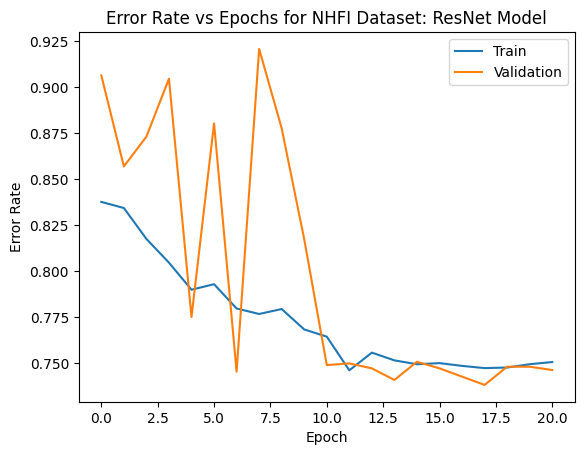

In [7]:
# Plot error rate vs epochs
import matplotlib.pyplot as plt
plt.plot(1 - np.array(history.history['accuracy']))
plt.plot(1 - np.array(history.history['val_accuracy']))
# plt.plot(1 - np.array(test_callback.test_acc))  # Plot test error rate
plt.title('Error Rate vs Epochs for NHFI Dataset: ResNet Model')
plt.ylabel('Error Rate')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation', 'Test'], loc='upper right')
plt.show()

RESNET - CLASSIFICATION REPORT - NHFI

In [ ]:
from sklearn.metrics import classification_report
import numpy as np

# Predict the values from the test set
y_pred = model.predict(X_test, verbose=1)

# Convert predictions from one-hot encoded to label encoded 
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert test labels from one-hot encoded to label encoded 
y_true = np.argmax(y_test, axis=1)

# Classes names
class_names = ['anger', 'contempt', 'disgust', 'fear', 'happiness',  'neutrality', 'sadness', 'surprise']

# Generate and print the classification report
report = classification_report(y_true, y_pred_classes, target_names=class_names)
print(report)

RESNET - COMPUTING AND PLOTTING THE CONFUSION MATRIX - NHFI

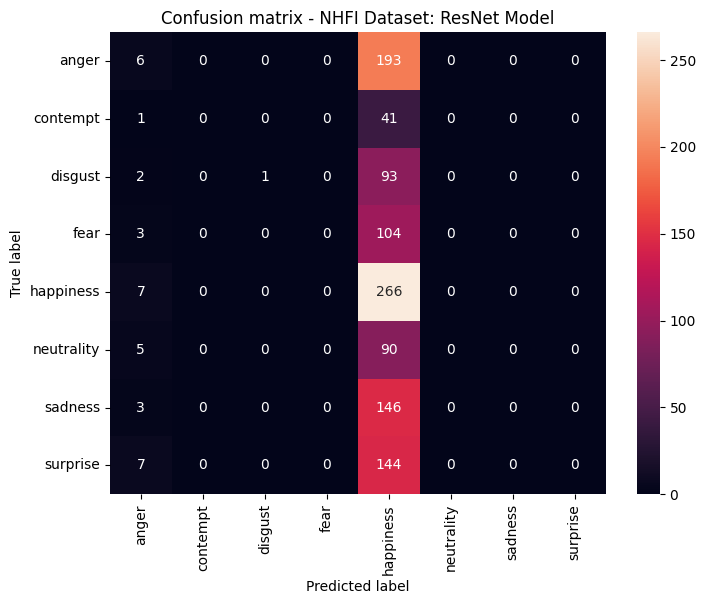

In [12]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Predict the values from the validation dataset
y_pred_classes = np.argmax(y_pred,axis = 1) 

# Convert validation observations to one hot vectors
y_true = np.argmax(y_test,axis = 1) 

# compute the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes)

# plot the confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(confusion_mtx, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names);
plt.title("Confusion matrix - NHFI Dataset: ResNet Model")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

RESNET - COMPUTING AND PLOTTING ROC CURVE - NHFI

In [11]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score
from itertools import cycle
import matplotlib.pyplot as plt

# Binarize the output
y_bin = label_binarize(y_test, classes=[0, 1, 2, 3, 4, 5, 6, 7])
n_classes = y_bin.shape[1]

# Compute the prediction
y_score = model.predict(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curve
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]))
for i, color in zip(range(n_classes), cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'yellow'])):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
                   ''.format(class_names[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - NHFI Dataset: ResNet Model')
plt.legend(loc="lower right")
plt.show()

35/35 [==============================] - 26s 727ms/step
